In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
###########################################################################################

def get_population_df_and_clean():

    df_population = pd.read_excel("estim-pop-dep-sexe-gca-1975-2018.xls", sheet_name = 4, skiprows=[0, 1, 2, 3])

    columns = df_population.columns

    ensemble_columns = list(map(lambda x : x, columns[2:8]))
    men_columns = list(map(lambda x : x[:-2] + " (H)", columns[8:14]))
    women_columns = list(map(lambda x : x[:-2] + " (F)", columns[14:]))

    new_columns = ["Département", "Nom département"] + ensemble_columns + men_columns + women_columns
    
    df_population.columns = new_columns
    df_population = df_population.dropna()
    df_population["Département"] = df_population["Département"].astype(str)
    
    return df_population

###########################################################################################

def get_fees_data_from_sheet_and_clean(sheet_name):
    
    df_fees = pd.read_excel("Honoraires.xls", sheet_name=sheet_name, na_values="nc")
    
    type_ = df_fees.columns[0]
    
    df_fees.columns = ["Spécialité", "Département", "Effectifs", "Honoraires sans dépassement", "Dépassements",
                       "Frais de déplacement", "Total des honoraires"]
    
    df_fees = df_fees[~df_fees["Département"].str.contains("TOTAL")]
    df_fees = df_fees[df_fees["Effectifs"] != 0]
    df_fees = df_fees.dropna()
    
    df_fees["Département"] = df_fees["Département"].apply(lambda x: re.sub(".*", x.split("-")[0], x))
    df_fees["Type"] = type_
    df_fees["Département"] = df_fees["Département"].astype(str)
   
    return df_fees

###########################################################################################

### Création d'un dataframe contenant les données de population et les données des différentes spécialités

In [3]:
sheet_names = ["Spécialistes", "Généralistes et MEP", "Dentistes et ODF", "Sages-femmes", "Auxiliaires médicaux"]

df_population = get_population_df_and_clean()
medical_fees = pd.concat(map(get_fees_data_from_sheet_and_clean, sheet_names))

fees_and_population_df = pd.merge(df_population, medical_fees, how="left", on=["Département"])
fees_and_population_df = fees_and_population_df.dropna()

fees_and_population_df["Proportion dépassement"] = fees_and_population_df["Dépassements"]/fees_and_population_df["Total des honoraires"]

### Création d'un dataframe pour les spécialités et un dataframe regroupant certaines spécialités par type

In [4]:
df_specialities = fees_and_population_df[~fees_and_population_df["Spécialité"].str.contains("TOTAL")]
df_totals = fees_and_population_df[fees_and_population_df["Spécialité"].str.contains("TOTAL")]

### Liste des spécialités

In [5]:
list(df_specialities.groupby("Spécialité").groups)

['01- M.E.P.',
 '01- Médecine générale',
 '01- OMNIPRATICIENS',
 '02- Anesthésie-réanimation chirurgicale',
 '03- Pathologie cardio-vasculaire',
 '04- Chirurgie générale',
 '05- Angiologie',
 '05- Dermato-vénéréologie',
 '06- Radiodiagnostic et imagerie médicale',
 '07- Gynécologie obstétrique',
 '08- Gastro-entérologie et hépatologie',
 '09- Médecine interne',
 '10- Neurochirurgie',
 '11- Oto-rhino-laryngologie',
 '12- Pédiatrie',
 '13- Pneumologie',
 '14- Rhumatologie',
 '15- Ophtalmologie',
 '16- Chirurgie urologique',
 '17- Neuropsychiatrie',
 '18- Stomatologie',
 '19- Chirurgiens-dentistes',
 '21- Sages-femmes',
 '24- Infirmiers',
 '26- Masseurs-kinésithérapeutes-rééducateurs',
 '27- Pédicures',
 '28- Orthophonistes',
 '29- Orthoptistes',
 '31- Médecine Physique et de Réadaptation',
 '32- Neurologie',
 '33- Psychiatrie',
 '35- Néphrologie',
 '36- Chirurgiens-dentistes, spécialistes O.D.F.',
 '37- Anatomo-cyto-pathologie',
 '41- Acupuncture et Médecine Générale',
 '41- Chirurgie or

### Liste des groupes de spécialité

In [6]:
list(df_totals.groupby("Spécialité").groups)

['TOTAL ANESTHESIE REANIMATION  (02, 20)',
 'TOTAL AUXILIAIRES MEDICAUX',
 'TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04)',
 'TOTAL CHIRURGIE DENTAIRE',
 'TOTAL GYNECOLOGIE  (70, 77, 79, 07)',
 'TOTAL MEDECINE INTERNE  (71, 73, 09)',
 'TOTAL MEDECINS',
 'TOTAL PEDIATRIE  (78, 12)',
 'TOTAL PSYCHIATRIE  (75, 33)',
 'TOTAL RADIOLOGIE  (72, 74, 76, 06)',
 'TOTAL SPECIALISTES',
 'TOTAL STOMATOLOGIE  (45, 18)']

### Nombre de praticiens (pour 100 000 habitants) par spécialité

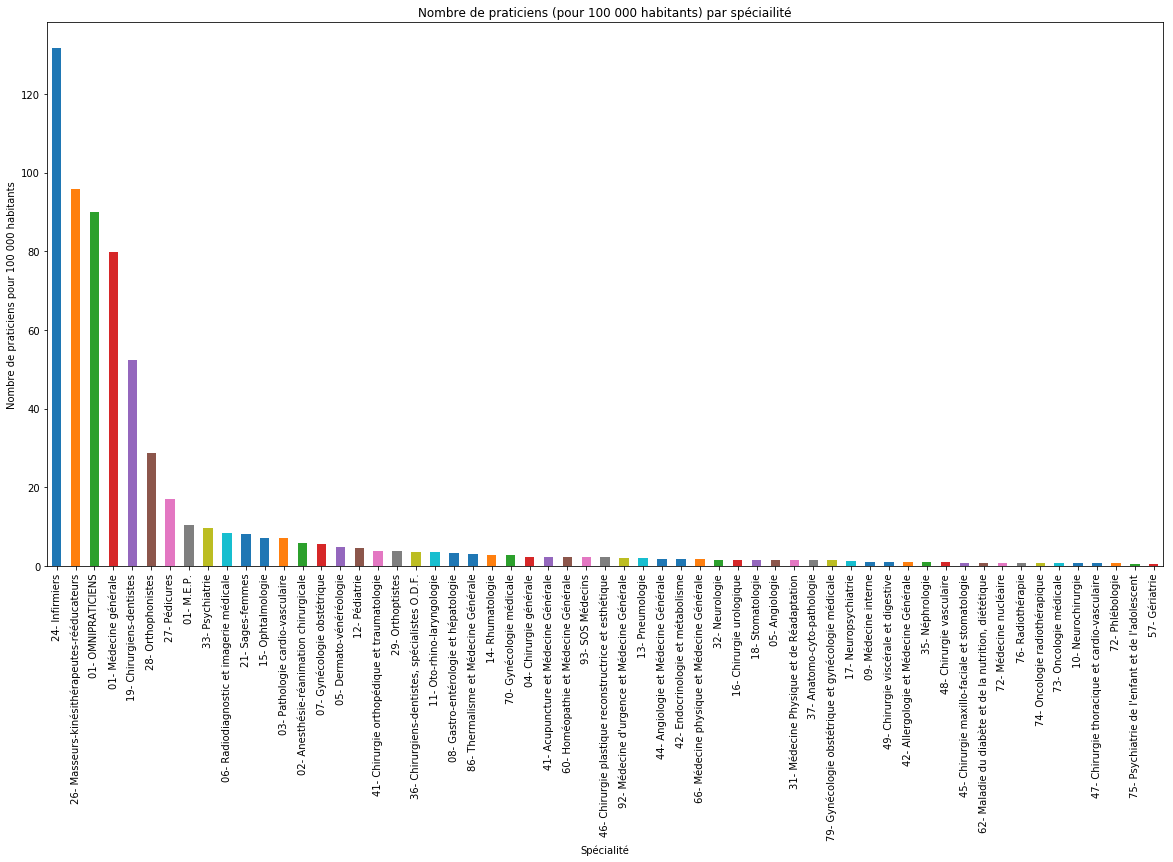

In [7]:
df = df_specialities.groupby('Spécialité')['Effectifs', 'Total'].mean()
df["Densité"] = df['Effectifs']/df['Total']*100000
df = df.sort_values(by='Densité', ascending=False)

plt.figure(figsize=(16,5))
df["Densité"].plot(kind='bar', figsize=(20,10))
plt.xticks(rotation=90)
plt.ylabel('Nombre de praticiens pour 100 000 habitants')
plt.title("Nombre de praticiens (pour 100 000 habitants) par spéciailité")
plt.show()

### Proportion de dépassement par spécialité

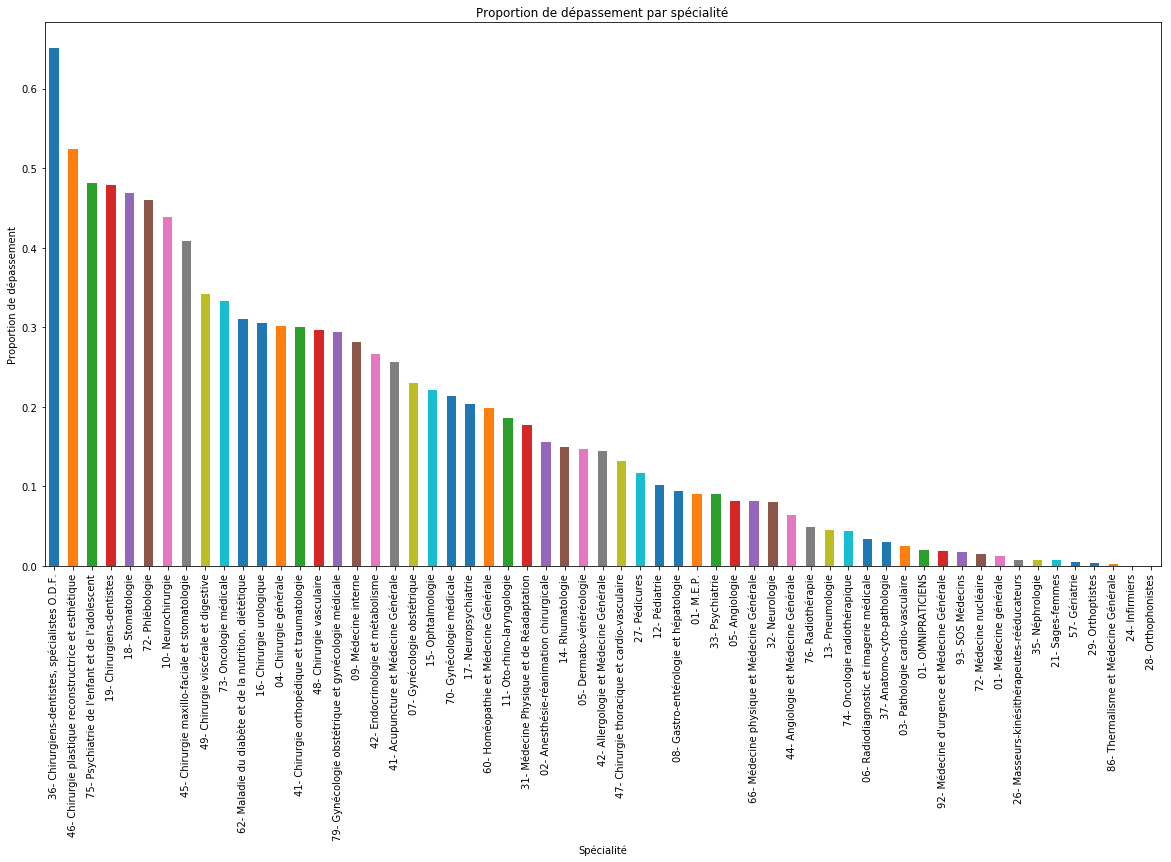

In [8]:
df = df_specialities.groupby('Spécialité')['Proportion dépassement'].mean().to_frame()
df = df.sort_values(by='Proportion dépassement', ascending=False)

plt.figure(figsize=(16,5))
df['Proportion dépassement'].plot(kind='bar', figsize=(20,10))
plt.xticks(rotation=90)
plt.ylabel('Proportion de dépassement')
plt.title("Proportion de dépassement par spécialité")
plt.show()

### Proportion de dépassement par département

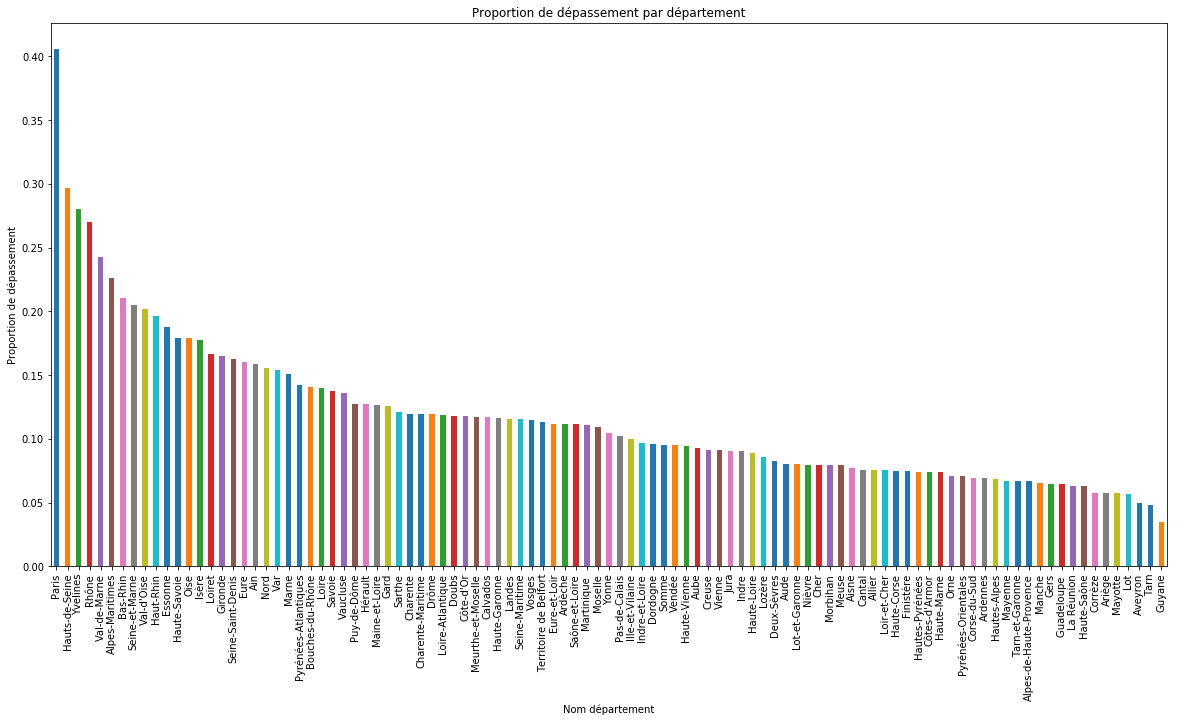

In [9]:
df = df_specialities.groupby('Nom département')['Proportion dépassement'].mean().to_frame()
df = df.sort_values(by='Proportion dépassement', ascending=False)

plt.figure(figsize=(20,10))
df['Proportion dépassement'].plot(kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Proportion de dépassement')
plt.title("Proportion de dépassement par département")
plt.show()

On voit que la proportion de dépassement est significativement plus importante à Paris que dans le reste de la france. Regardons ce qu'il en ait spécialité par spécialité.

### Comparaison entre Paris-France pour la proportion de dépassement

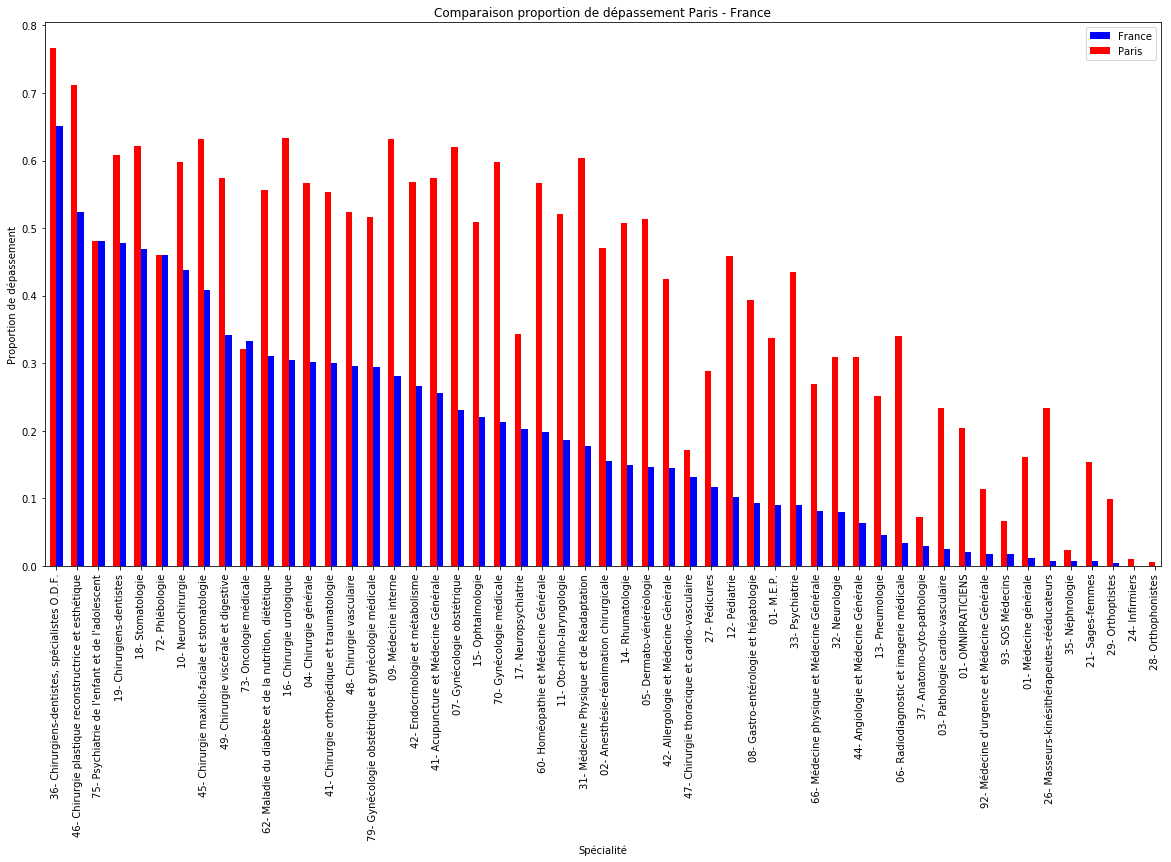

In [10]:
df = df_specialities.groupby('Spécialité')['Proportion dépassement'].mean().to_frame()
df = df.sort_values(by='Proportion dépassement', ascending=False)

paris_data = df_specialities[df_specialities["Département"] == "75"]
paris_data = paris_data.sort_values(by='Proportion dépassement', ascending=False)
paris_data = paris_data[['Spécialité', 'Proportion dépassement']]

merge_df = pd.merge(df, paris_data, how="left", on=["Spécialité"]).dropna().set_index("Spécialité")

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
merge_df["Proportion dépassement_x"].plot(kind='bar', ax=ax, color = "blue", width=0.3, position=0, label = "France")
merge_df["Proportion dépassement_y"].plot(kind='bar', ax=ax, color='red', width=0.3, position=1, label = "Paris")
plt.xticks(rotation=90)
plt.ylabel('Proportion de dépassement')
plt.title("Comparaison proportion de dépassement Paris - France")
plt.legend()
plt.show()

### Lien entre la densité de médecins et la proportion de dépassement

R2 : 0.26


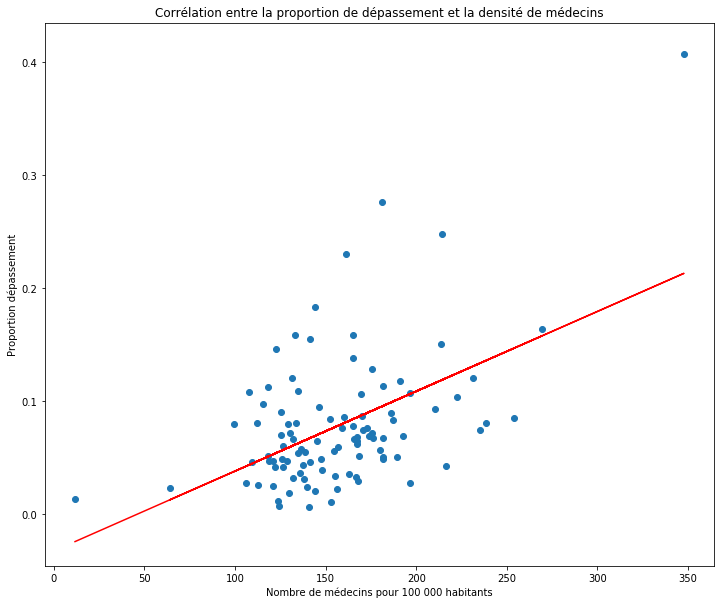

In [11]:
all_doctors = df_totals[df_totals["Spécialité"] == "TOTAL MEDECINS"] 


density_values = (all_doctors["Effectifs"]/all_doctors["Total"]*100000).values
extra_fees_values = all_doctors["Proportion dépassement"].values

linearRegression = LinearRegression()
linearRegression.fit(density_values.reshape(-1, 1), extra_fees_values)
score = linearRegression.score(density_values.reshape(-1, 1), extra_fees_values)

print("==========")
print(f"R2 : %.2f" % score)
print("==========")

fig = plt.figure(figsize=(12, 10))
plt.scatter(density_values, extra_fees_values)
plt.plot(density_values, linearRegression.intercept_ + linearRegression.coef_*density_values, color = "red")

plt.xlabel("Nombre de médecins pour 100 000 habitants")
plt.ylabel("Proportion dépassement")
plt.title("Corrélation entre la proportion de dépassement et la densité de médecins");

Il n'y a pas de lien vraiment clair entre la densité de médecins et la proportion de dépassement (le score de la régression est relativement faible). Une tendance semble cependant se dégager, selon laquelle la proportion de dépassement est la plus élevée là où la densité de médecins est la plus grande. Cela paraît contre intuitif dans la mesure où les prix sont le plus élevés là où l'offre de médecins est la plus grande.  

### Nombre de médecins (pour 100 000 habitants) par département

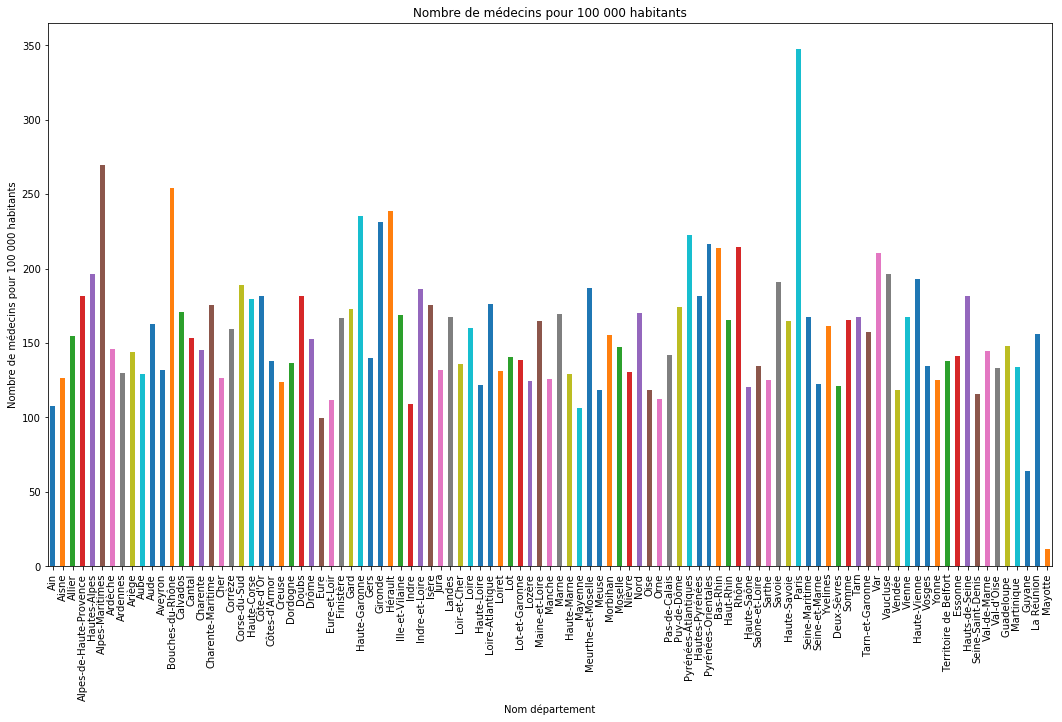

In [12]:
all_doctors = df_totals[df_totals["Spécialité"] == "TOTAL MEDECINS"].set_index("Nom département")

fig = plt.figure(figsize=(18, 10))
(all_doctors["Effectifs"]/all_doctors["Total"]*100000).plot(kind = "bar")
plt.ylabel("Nombre de médecins pour 100 000 habitants")
plt.title("Nombre de médecins pour 100 000 habitants")
plt.show()

A part le département de Mayotte, on ne peut pas dire qu'il y ait de "désert" médical en France, en tout cas à l'échelle départementale.

### Lien entre la densité d'infirmiers et la proportion de personnes âgées (75 ans et plus)

R2 : 0.17


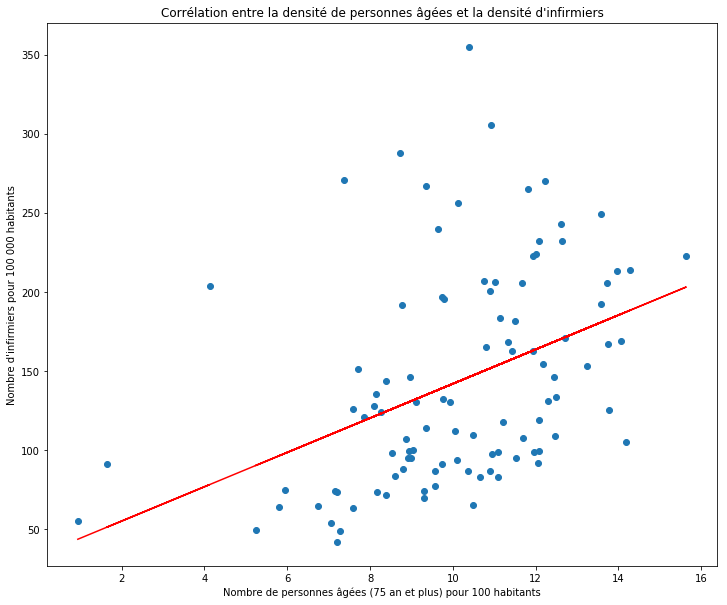

In [13]:
nurses = df_specialities[df_specialities["Spécialité"].str.contains("Infirmiers")]

old_density_values = (nurses["75 ans et plus"]/nurses["Total"]*100).values.reshape(-1, 1)
nurses_density_values = (nurses["Effectifs"]/nurses["Total"]*100000).values

linearRegression = LinearRegression()
linearRegression.fit(old_density_values, nurses_density_values)
score = linearRegression.score(old_density_values, nurses_density_values)

print("==========")
print(f"R2 : %.2f" % score)
print("==========")

fig = plt.figure(figsize=(12, 10))

plt.scatter(old_density_values, nurses_density_values)
plt.plot(old_density_values, linearRegression.intercept_ + linearRegression.coef_*old_density_values, color = "red")
plt.xlabel("Nombre de personnes âgées (75 an et plus) pour 100 habitants")
plt.ylabel("Nombre d'infirmiers pour 100 000 habitants")
plt.title("Corrélation entre la densité de personnes âgées et la densité d'infirmiers");
plt.show()

Même si la logique semble être respectée, à savoir qu'il y a plus d'infirmiers dans les départements où il y a le plus de personnes âgées, la corrélation n'est pas très claire.

### Effectifs et proportion de dépassement par département pour les sages-femmes

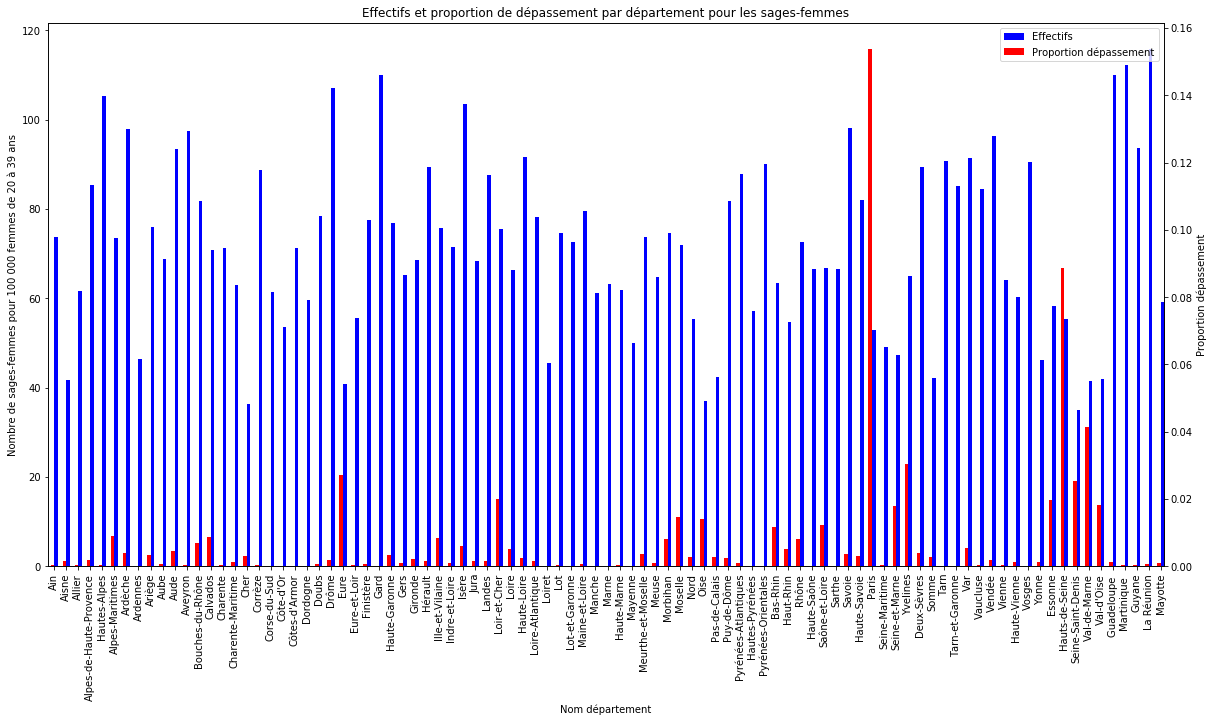

In [14]:
df = df_specialities[df_specialities["Spécialité"].str.contains("21- Sages-femmes")]
df = df.set_index("Nom département")[["20 à 39 ans (F)", "Effectifs", "Proportion dépassement"]]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax1 = ax.twinx()

(df["Effectifs"]/df["20 à 39 ans (F)"]*100000).plot(kind='bar', ax=ax, color = "blue", width=0.3, position=0,\
                                                    label = "Effectifs")
df["Proportion dépassement"].plot(kind='bar', ax=ax1, color='red', width=0.3, position=1)

ax.set_ylabel("Nombre de sages-femmes pour 100 000 femmes de 20 à 39 ans")
ax1.set_ylabel("Proportion dépassement")
hist, labels = ax.get_legend_handles_labels()
hist2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(hist + hist2, labels + labels2, loc=0)
plt.title("Effectifs et proportion de dépassement par département pour les sages-femmes")
plt.xticks(rotation=90)
plt.show()

On voit clairement que certains départements sont avantagés quand à l'accouchement. Le département de la Drôme par exemple possède une des densités de sage-femmes les plus élevées, et un des taux de dépassement les plus faibles. Il ne vaut mieux pas avoir d'enfants à Paris en revanche !